<a href="https://colab.research.google.com/github/fatazeouedraogo/Deep-Learning-for-Healthcare-Brain-Tumor-Classification-using-VGG16/blob/main/ML_Project_553.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJET FINAL - MACHINE LEARNING
SCD1502 - Burkina Institute of Technology
# Prédiction de la Facturation et du Churn Client

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc,
                             precision_recall_curve, classification_report)
import warnings
warnings.filterwarnings('ignore')


# Graph Configuaration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Toutes les bibliothèques importées avec succès\n")

 Toutes les bibliothèques importées avec succès



Generation des données

In [ ]:

#GÉNÉRATION DES DONNÉES PERSONNALISÉES

STUDENT_ID = 553

np.random.seed(STUDENT_ID)
n_samples = 800 + (STUDENT_ID % 200)

print(f"{'='*80}")
print(f"GÉNÉRATION DES DONNÉES - ID ÉTUDIANT: {STUDENT_ID}")
print(f"{'='*80}\n")

# Génération des caractéristiques
age = np.random.randint(18, 70, n_samples)
tenure_months = np.random.randint(1, 120, n_samples)
num_lines = np.random.randint(1, 5, n_samples)
data_usage_gb = np.random.exponential(5, n_samples) + np.random.rand(n_samples) * 3
call_minutes = np.random.exponential(200, n_samples)
num_complaints = np.random.poisson(1.5, n_samples)
satisfaction_score = np.random.randint(1, 11, n_samples)
contract_type = np.random.choice(['Monthly', 'Annual', 'Bi-annual'], n_samples,
                                 p=[0.5, 0.35, 0.15])
payment_method = np.random.choice(['Card', 'Transfer', 'Mobile_Money', 'Cash'],
                                  n_samples)

# Target de régression: Facture mensuelle
bill = (15 +
        0.8 * data_usage_gb +
        0.02 * call_minutes +
        5 * num_lines +
        np.where(contract_type == 'Monthly', 5,
                np.where(contract_type == 'Annual', -3, -8)) +
        np.random.normal(0, 3, n_samples))
bill = np.maximum(bill, 5)

# Target de classification: Churn
prob_churn = 1 / (1 + np.exp(-(
    -2 +
    0.03 * num_complaints * 2 -
    0.01 * tenure_months -
    0.15 * satisfaction_score +
    0.5 * (contract_type == 'Monthly').astype(int) +
    np.random.normal(0, 0.3, n_samples)
)))
churn = (np.random.rand(n_samples) < prob_churn).astype(int)

# Création du DataFrame
df = pd.DataFrame({
    'age': age,
    'tenure_months': tenure_months,
    'num_lines': num_lines,
    'data_usage_gb': np.round(data_usage_gb, 2),
    'call_minutes': np.round(call_minutes, 1),
    'num_complaints': num_complaints,
    'satisfaction_score': satisfaction_score,
    'contract_type': contract_type,
    'payment_method': payment_method,
    'monthly_bill': np.round(bill, 2),
    'churn': churn
})

# Sauvegarde
df.to_csv(f'telecom_data_{STUDENT_ID:05d}.csv', index=False)

print(f" Dataset généré: {len(df)} lignes")
print(f" Taux de churn: {df['churn'].mean()*100:.1f}%")
print(f"Facture moyenne: {df['monthly_bill'].mean():.2f} $\n")
print(df.head(10))
print(f"\nForme du dataset: {df.shape}")



GÉNÉRATION DES DONNÉES - ID ÉTUDIANT: 553

 Dataset généré: 953 lignes
 Taux de churn: 5.4%
Facture moyenne: 36.52 $

   age  tenure_months  num_lines  data_usage_gb  call_minutes  num_complaints  \
0   28             87          2           3.16         274.6               0   
1   23              8          2          22.71          38.2               0   
2   65             90          2          19.52         284.6               1   
3   25            100          3           1.54         147.9               0   
4   62             92          1           2.99          28.8               2   
5   60             72          1          16.53         134.1               2   
6   64              3          4           0.69         276.1               0   
7   24             84          1           5.71          35.1               1   
8   28             42          2           5.56         235.4               1   
9   42             69          3           8.94         659.6           

# PARTIE 1.1 : ANALYSE EXPLORATOIRE

In [ ]:

print(f"\n{'='*80}")
print("PARTIE 1.1 : EXPLORATION DES DONNÉES")
print(f"{'='*80}\n")

# Statistiques descriptives
print("STATISTIQUES DESCRIPTIVES:")
print(df.describe())

# Informations sur les colonnes
print("\n-->INFORMATIONS SUR LES COLONNES<---")
print(df.info())


PARTIE 1.1 : EXPLORATION DES DONNÉES

STATISTIQUES DESCRIPTIVES:
              age  tenure_months   num_lines  data_usage_gb  call_minutes  \
count  953.000000     953.000000  953.000000     953.000000    953.000000   
mean    43.406086      60.203568    2.482686       6.465341    197.721931   
std     15.113014      33.840247    1.119895       4.905606    190.409439   
min     18.000000       1.000000    1.000000       0.140000      0.100000   
25%     30.000000      32.000000    1.000000       3.060000     60.600000   
50%     43.000000      59.000000    2.000000       5.090000    138.500000   
75%     57.000000      90.000000    3.000000       8.540000    280.100000   
max     69.000000     119.000000    4.000000      43.170000   1096.300000   

       num_complaints  satisfaction_score  monthly_bill       churn  
count      953.000000          953.000000    953.000000  953.000000  
mean         1.490031            5.639035     36.517240    0.053515  
std          1.211012         

Histogramme

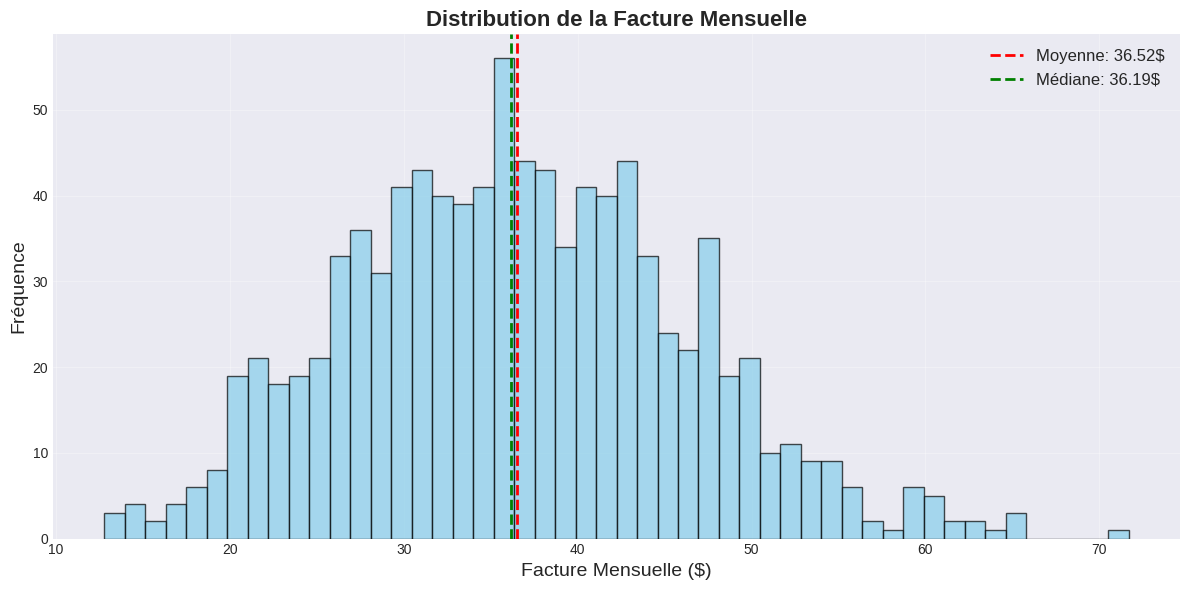

 Min: 12.78$ | Max: 71.69$


In [ ]:

plt.figure(figsize=(12, 6))
plt.hist(df['monthly_bill'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df['monthly_bill'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Moyenne: {df["monthly_bill"].mean():.2f}$')
plt.axvline(df['monthly_bill'].median(), color='green', linestyle='--', linewidth=2,
            label=f'Médiane: {df["monthly_bill"].median():.2f}$')
plt.xlabel('Facture Mensuelle ($)', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Distribution de la Facture Mensuelle', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f" Min: {df['monthly_bill'].min():.2f}$ | Max: {df['monthly_bill'].max():.2f}$")

 Distribution du Churn

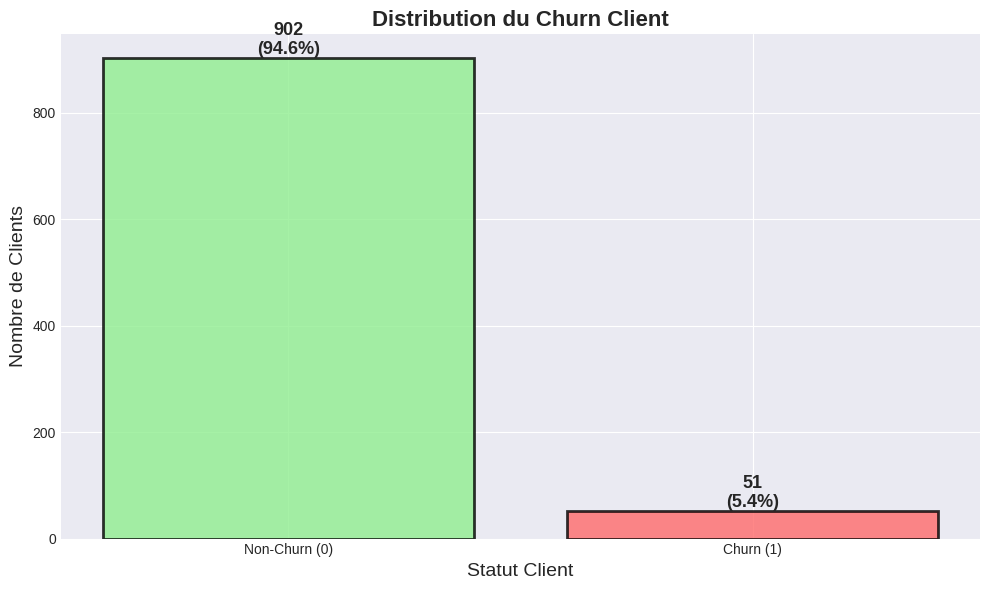

Non-Churn: 902 clients (94.6%)
Churn: 51 clients (5.4%)


In [ ]:
# Bar chart du churn
plt.figure(figsize=(10, 6))
churn_counts = df['churn'].value_counts()
colors = ['#90EE90', '#FF6B6B']
bars = plt.bar(['Non-Churn (0)', 'Churn (1)'], churn_counts.values,
               color=colors, edgecolor='black', alpha=0.8, linewidth=2)

plt.xlabel('Statut Client', fontsize=14)
plt.ylabel('Nombre de Clients', fontsize=14)
plt.title('Distribution du Churn Client', fontsize=16, fontweight='bold')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Non-Churn: {churn_counts[0]} clients ({churn_counts[0]/len(df)*100:.1f}%)")
print(f"Churn: {churn_counts[1]} clients ({churn_counts[1]/len(df)*100:.1f}%)")

 Matrice de corrélation

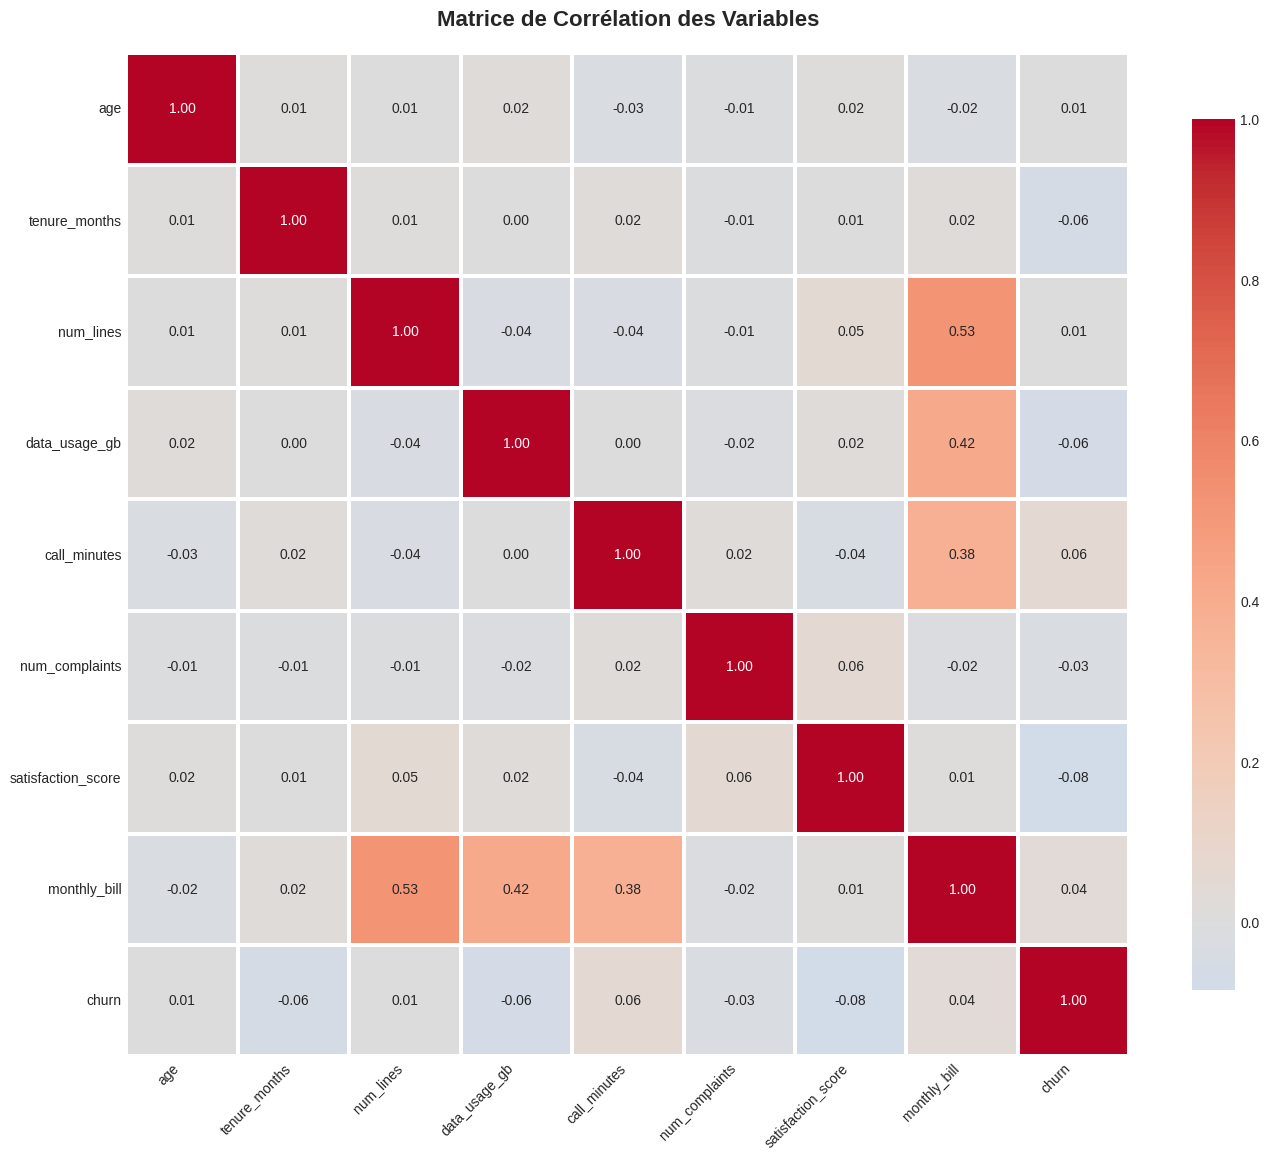

 Corrélations les plus fortes avec monthly_bill:
num_lines        0.528439
data_usage_gb    0.418676
call_minutes     0.377215
Name: monthly_bill, dtype: float64

Corrélations les plus fortes avec churn:
call_minutes    0.059586
monthly_bill    0.040827
age             0.007497
Name: churn, dtype: float64


In [ ]:
# LA  Matrice de corrélation
plt.figure(figsize=(14, 12))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 10})
plt.title('Matrice de Corrélation des Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(" Corrélations les plus fortes avec monthly_bill:")
bill_corr = correlation_matrix['monthly_bill'].sort_values(ascending=False)
print(bill_corr[bill_corr.index != 'monthly_bill'].head(3))

print("\nCorrélations les plus fortes avec churn:")
churn_corr = correlation_matrix['churn'].sort_values(ascending=False)
print(churn_corr[churn_corr.index != 'churn'].head(3))

# PARTIE 1.2 : PRÉTRAITEMENT DES DONNÉES

 PREPROCESSING ( Encodage et split )

In [ ]:

#  PRÉTRAITEMENT DES DONNÉES


print(f"\n{'='*80}")
print(" PARTIE 1.2 : PRÉTRAITEMENT")
print(f"{'='*80}\n")

# Encodage des variables catégorielles
le_contract = LabelEncoder()
le_payment = LabelEncoder()

df_encoded = df.copy()
df_encoded['contract_type_encoded'] = le_contract.fit_transform(df['contract_type'])
df_encoded['payment_method_encoded'] = le_payment.fit_transform(df['payment_method'])

print(" Encodage des variables catégorielles:")
print(f"   contract_type: {dict(enumerate(le_contract.classes_))}")
print(f"   payment_method: {dict(enumerate(le_payment.classes_))}\n")

# Séparation features/targets
X = df_encoded[['age', 'tenure_months', 'num_lines', 'data_usage_gb',
                'call_minutes', 'num_complaints', 'satisfaction_score',
                'contract_type_encoded', 'payment_method_encoded']]
y_regression = df_encoded['monthly_bill']
y_classification = df_encoded['churn']

# Split train/test pour la régression
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=STUDENT_ID)

# Split train/test pour la classification
X_train_clf, X_test_clf, y_clf_train, y_clf_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=STUDENT_ID)

# Standardisation
scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f" Division des données (random_state={STUDENT_ID}):")
print(f"   X_train: {X_train_scaled.shape}")
print(f"   X_test: {X_test_scaled.shape}")
print(f"   Ratio: {len(X_train)/len(X)*100:.0f}% Train / {len(X_test)/len(X)*100:.0f}% Test")
print(f"\n   Distribution du churn dans le train: {y_clf_train.mean()*100:.1f}%")
print(f"   Distribution du churn dans le test: {y_clf_test.mean()*100:.1f}%")


 PARTIE 1.2 : PRÉTRAITEMENT

 Encodage des variables catégorielles:
   contract_type: {0: 'Annual', 1: 'Bi-annual', 2: 'Monthly'}
   payment_method: {0: 'Card', 1: 'Cash', 2: 'Mobile_Money', 3: 'Transfer'}

 Division des données (random_state=553):
   X_train: (762, 9)
   X_test: (191, 9)
   Ratio: 80% Train / 20% Test

   Distribution du churn dans le train: 5.0%
   Distribution du churn dans le test: 6.8%


#  PARTIE 2 : RÉGRESSION LINÉAIRE  

In [ ]:

#  RÉGRESSION LINÉAIRE - PRÉDICTION DE LA FACTURE


print(f"\n{'='*80}")
print(" PARTIE 2.1 : RÉGRESSION LINÉAIRE")
print(f"{'='*80}\n")

# Entraînement du modèle
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_reg_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Calcul des métriques
mse = mean_squared_error(y_reg_test, y_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_reg_test, y_pred_lr)
r2 = r2_score(y_reg_test, y_pred_lr)

print(" MÉTRIQUES DE PERFORMANCE:")
print(f"  • MSE (Erreur Quadratique Moyenne)    : {mse:.4f}")
print(f"  • RMSE (Racine de l'Erreur Quadratique): {rmse:.4f} $")
print(f"  • MAE (Erreur Absolue Moyenne)         : {mae:.4f} $")
print(f"  • R² (Coefficient de Détermination)    : {r2:.4f}")
print(f" Interprétation du R² : Le modèle explique {r2*100:.1f}% de la variance des factures")
print()

# Coefficients du modèle
feature_names = X.columns
coefficients = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(" COEFFICIENTS DU MODÈLE (triés par importance):")
print(coefficients.to_string(index=False))
print(f"\n   Intercept (Ordonnée à l'origine): {lr_model.intercept_:.4f} $\n")

print("="*80)
print(" INTERPRÉTATION DES 3 COEFFICIENTS LES PLUS IMPORTANTS:")
print("="*80)

for idx, (_, row) in enumerate(coefficients.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['Variable']} (Coefficient: {row['Coefficient']:.4f})")

    if 'data_usage' in row['Variable']:
        print(f"   → Chaque Go de données consommé augmente la facture de {abs(row['Coefficient']):.2f}$")
        print(f"   → Impact MAJEUR : La consommation data est le driver principal du coût")
    elif 'num_lines' in row['Variable']:
        print(f"   → Chaque ligne téléphonique supplémentaire ajoute {abs(row['Coefficient']):.2f}$ à la facture")
        print(f"   → Logique commerciale : Plus de lignes = plus de services = facture plus élevée")
    elif 'call_minutes' in row['Variable']:
        print(f"   → Chaque minute d'appel augmente la facture de {abs(row['Coefficient']):.4f}$")
        print(f"   → Impact modéré mais cumulatif sur le coût mensuel")
    elif 'contract' in row['Variable']:
        if row['Coefficient'] > 0:
            print(f"   → Ce type de contrat coûte {abs(row['Coefficient']):.2f}$ de plus par mois")
        else:
            print(f"   → Ce type de contrat offre une réduction de {abs(row['Coefficient']):.2f}$ par mois")
        print(f"   → Stratégie : Fidéliser avec des réductions long terme")
    else:
        print(f"   → Impact de {'+' if row['Coefficient'] > 0 else ''}{row['Coefficient']:.2f}$ par unité")
print()


 PARTIE 2.1 : RÉGRESSION LINÉAIRE

 MÉTRIQUES DE PERFORMANCE:
  • MSE (Erreur Quadratique Moyenne)    : 22.3518
  • RMSE (Racine de l'Erreur Quadratique): 4.7278 $
  • MAE (Erreur Absolue Moyenne)         : 3.6840 $
  • R² (Coefficient de Détermination)    : 0.7832
 Interprétation du R² : Le modèle explique 78.3% de la variance des factures

 COEFFICIENTS DU MODÈLE (triés par importance):
              Variable  Coefficient
             num_lines     5.349143
          call_minutes     4.050604
         data_usage_gb     3.888321
 contract_type_encoded     3.838918
        num_complaints    -0.156665
payment_method_encoded    -0.147269
         tenure_months    -0.096525
    satisfaction_score    -0.077203
                   age    -0.062255

   Intercept (Ordonnée à l'origine): 36.2694 $

 INTERPRÉTATION DES 3 COEFFICIENTS LES PLUS IMPORTANTS:

1. num_lines (Coefficient: 5.3491)
   → Chaque ligne téléphonique supplémentaire ajoute 5.35$ à la facture
   → Logique commerciale : Plus de

Graphique Actual vs Predicted

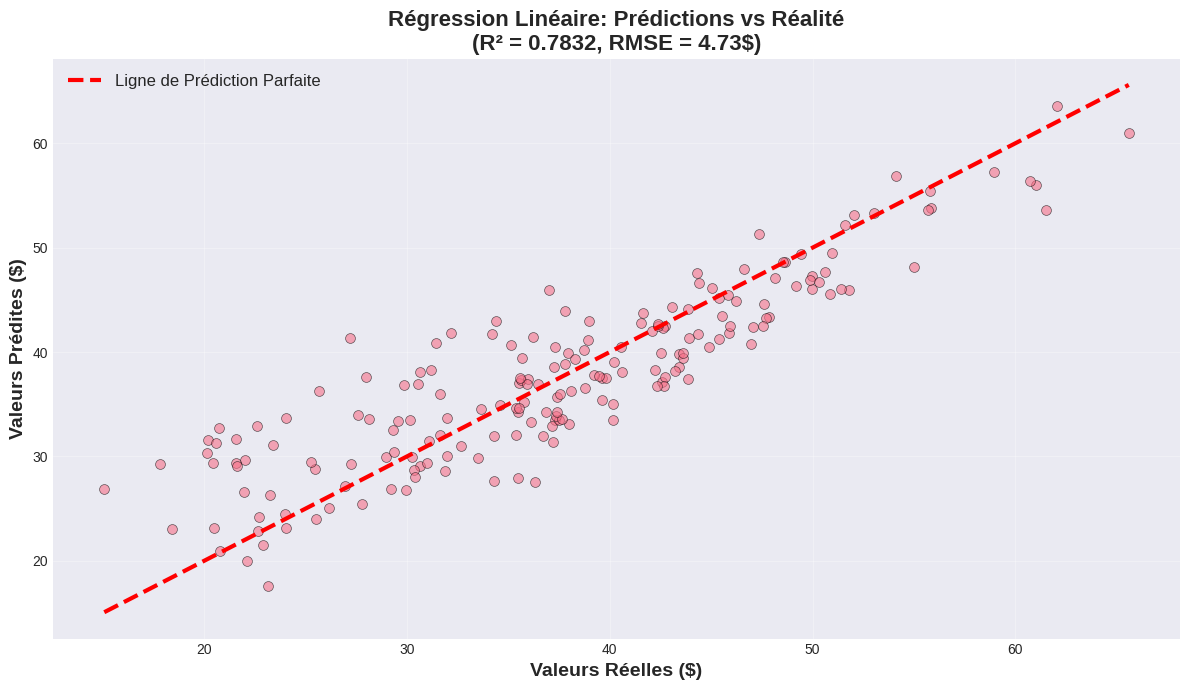

 ANALYSE DES RÉSIDUS:
   • Résidu moyen: -0.2112 $ (proche de 0 = bon)
   • Écart-type des résidus: 4.7355 $
   • Résidu min: -14.22 $ | Résidu max: 8.76 $
 .Resumé min : 


In [ ]:
# Graphique Valeurs Réelles vs Prédites
plt.figure(figsize=(12, 7))
plt.scatter(y_reg_test, y_pred_lr, alpha=0.6, s=50, edgecolor='k', linewidth=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         'r--', lw=3, label='Ligne de Prédiction Parfaite')

plt.xlabel('Valeurs Réelles ($)', fontsize=14, fontweight='bold')
plt.ylabel('Valeurs Prédites ($)', fontsize=14, fontweight='bold')
plt.title(f'Régression Linéaire: Prédictions vs Réalité\n(R² = {r2:.4f}, RMSE = {rmse:.2f}$)',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyse des résidus
residuals = y_reg_test - y_pred_lr
print(f" ANALYSE DES RÉSIDUS:")
print(f"   • Résidu moyen: {residuals.mean():.4f} $ (proche de 0 = bon)")
print(f"   • Écart-type des résidus: {residuals.std():.4f} $")
print(f"   • Résidu min: {residuals.min():.2f} $ | Résidu max: {residuals.max():.2f} $")
print(f" .Resumé min : ")

#  PARTIE 2.2 : RÉGRESSION POLYNOMIALE

In [ ]:


print(f"\n{'='*80}")
print(" PARTIE 2.2 : RÉGRESSION POLYNOMIALE")
print(f"{'='*80}\n")

degrees = range(1, 6)
results_poly = []

print(" Test des degrés polynomiaux en cours...\n")

for degree in degrees:
    # Transformation polynomiale
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Entraînement
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_reg_train)

    # Scores
    r2_train = model_poly.score(X_train_poly, y_reg_train)
    r2_test = model_poly.score(X_test_poly, y_reg_test)
    overfit = r2_train - r2_test

    results_poly.append({
        'Degré': degree,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'Écart (Overfit)': overfit
    })

    print(f"   Degré {degree}: R² Train = {r2_train:.4f} | R² Test = {r2_test:.4f} | Écart = {overfit:.4f}")

poly_df = pd.DataFrame(results_poly)

print(f"\n{'='*80}")
print(" TABLEAU RÉCAPITULATIF:")
print(f"{'='*80}")
print(poly_df.to_string(index=False))
print()


 PARTIE 2.2 : RÉGRESSION POLYNOMIALE

 Test des degrés polynomiaux en cours...

   Degré 1: R² Train = 0.7987 | R² Test = 0.7832 | Écart = 0.0156
   Degré 2: R² Train = 0.9085 | R² Test = 0.9092 | Écart = -0.0007
   Degré 3: R² Train = 0.9299 | R² Test = 0.8584 | Écart = 0.0714
   Degré 4: R² Train = 0.9953 | R² Test = -4.4756 | Écart = 5.4709
   Degré 5: R² Train = 1.0000 | R² Test = -0.0199 | Écart = 1.0199

 TABLEAU RÉCAPITULATIF:
 Degré  R² Train   R² Test  Écart (Overfit)
     1  0.798740  0.783171         0.015569
     2  0.908524  0.909186        -0.000662
     3  0.929857  0.858409         0.071447
     4  0.995312 -4.475634         5.470946
     5  1.000000 -0.019881         1.019881



Graphique comparatif + Analyse

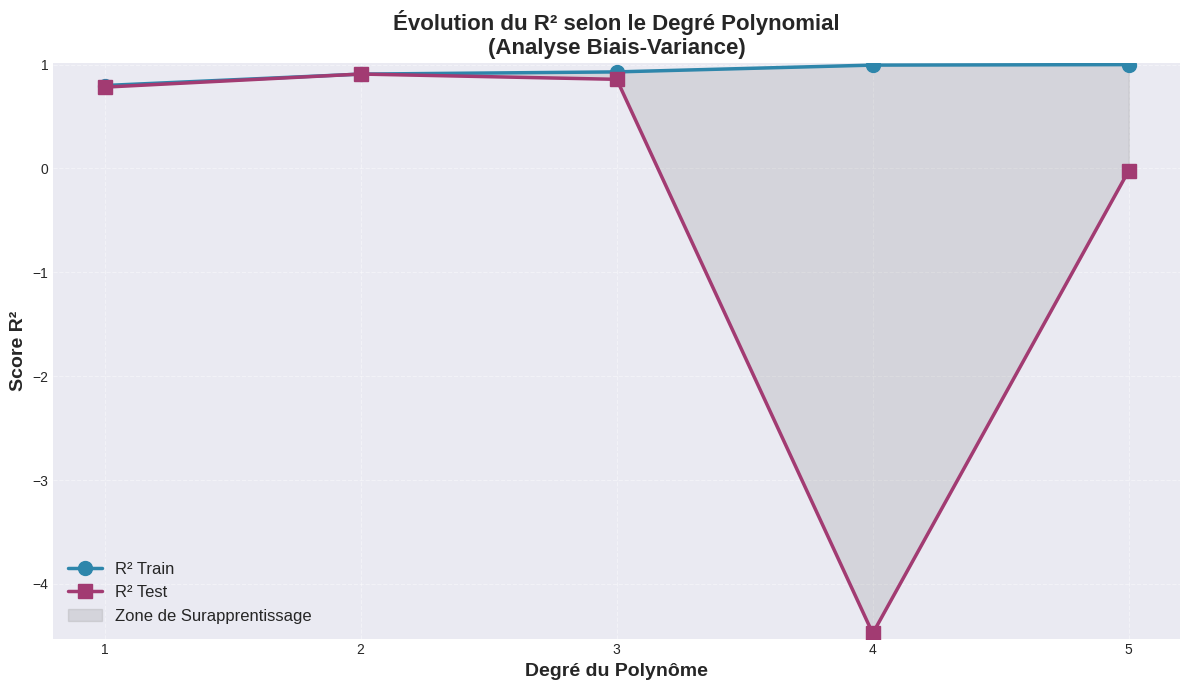


 MEILLEUR DEGRÉ POLYNOMIAL: 2
   • R² Train: 0.9085
   • R² Test : 0.9092
   • Écart   : -0.0007

 EXPLICATION BIAIS-VARIANCE:
────────────────────────────────────────────────────────────────────────────────

   🔹 DEGRÉ 1 (Régression Linéaire Simple):
      • BIAIS ÉLEVÉ : Modèle trop simple (sous-apprentissage)
      • VARIANCE FAIBLE : Stable mais imprécis
      • Performance limitée (R² Test = 0.7832)

   🔹 DEGRÉ 2 (OPTIMAL) :
      • BIAIS MODÉRÉ : Capture bien les relations complexes
      • VARIANCE MODÉRÉE : Bon équilibre entre complexité et généralisation
      • Meilleur compromis (R² Test = 0.9092)
      • L'écart Train-Test reste acceptable

   🔹 DEGRÉS ÉLEVÉS (5 et plus):
      • BIAIS FAIBLE : Très précis sur les données d'entraînement
      • VARIANCE ÉLEVÉE : Surapprentissage (overfitting)
      • R² Test diminue (-0.0199) = mauvaise généralisation
      • Le modèle mémorise le bruit des données

 CONCLUSION: Le degré optimal équilibre la complexité du modèle
   et sa c

In [ ]:
# Graphique de comparaison
plt.figure(figsize=(12, 7))
plt.plot(poly_df['Degré'], poly_df['R² Train'], 'o-',
         linewidth=2.5, markersize=10, label='R² Train', color='#2E86AB')
plt.plot(poly_df['Degré'], poly_df['R² Test'], 's-',
         linewidth=2.5, markersize=10, label='R² Test', color='#A23B72')
plt.fill_between(poly_df['Degré'], poly_df['R² Train'], poly_df['R² Test'],
                 alpha=0.2, color='gray', label='Zone de Surapprentissage')

plt.xlabel('Degré du Polynôme', fontsize=14, fontweight='bold')
plt.ylabel('Score R²', fontsize=14, fontweight='bold')
plt.title('Évolution du R² selon le Degré Polynomial\n(Analyse Biais-Variance)',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.4, linestyle='--')
plt.xticks(degrees)
plt.ylim([poly_df[['R² Train', 'R² Test']].min().min() - 0.05, 1.02])
plt.tight_layout()
plt.show()

# Identification du meilleur degré
best_degree = poly_df.loc[poly_df['R² Test'].idxmax()]

print(f"\n{'='*80}")
print(f" MEILLEUR DEGRÉ POLYNOMIAL: {int(best_degree['Degré'])}")
print(f"{'='*80}")
print(f"   • R² Train: {best_degree['R² Train']:.4f}")
print(f"   • R² Test : {best_degree['R² Test']:.4f}")
print(f"   • Écart   : {best_degree['Écart (Overfit)']:.4f}")
print()

print(" EXPLICATION BIAIS-VARIANCE:")
print("─"*80)
print()
print("   🔹 DEGRÉ 1 (Régression Linéaire Simple):")
print("      • BIAIS ÉLEVÉ : Modèle trop simple (sous-apprentissage)")
print("      • VARIANCE FAIBLE : Stable mais imprécis")
print(f"      • Performance limitée (R² Test = {poly_df.iloc[0]['R² Test']:.4f})")
print()
print(f"   🔹 DEGRÉ {int(best_degree['Degré'])} (OPTIMAL) :")
print("      • BIAIS MODÉRÉ : Capture bien les relations complexes")
print("      • VARIANCE MODÉRÉE : Bon équilibre entre complexité et généralisation")
print(f"      • Meilleur compromis (R² Test = {best_degree['R² Test']:.4f})")
print("      • L'écart Train-Test reste acceptable")
print()

if len(poly_df) >= 4:
    high_degree = poly_df.iloc[-1]
    print(f"   🔹 DEGRÉS ÉLEVÉS ({int(high_degree['Degré'])} et plus):")
    print("      • BIAIS FAIBLE : Très précis sur les données d'entraînement")
    print("      • VARIANCE ÉLEVÉE : Surapprentissage (overfitting)")
    print(f"      • R² Test diminue ({high_degree['R² Test']:.4f}) = mauvaise généralisation")
    print("      • Le modèle mémorise le bruit des données")
print()
print(" CONCLUSION: Le degré optimal équilibre la complexité du modèle")
print("   et sa capacité à généraliser sur de nouvelles données.")
print()

#  PARTIE 3.1 : CLASSIFICATION - LOGISTIC REGRESSION

 Modèle de classification

In [ ]:

print(f"\n{'='*80}")
print(" PARTIE 3.1 : RÉGRESSION LOGISTIQUE - PRÉDICTION DU CHURN")
print(f"{'='*80}\n")

# Modèle standard
log_reg = LogisticRegression(max_iter=1000, random_state=STUDENT_ID)
log_reg.fit(X_train_clf_scaled, y_clf_train)
y_pred_clf = log_reg.predict(X_test_clf_scaled)
y_pred_proba = log_reg.predict_proba(X_test_clf_scaled)[:, 1]

# Métriques
accuracy = accuracy_score(y_clf_test, y_pred_clf)
precision = precision_score(y_clf_test, y_pred_clf)
recall = recall_score(y_clf_test, y_pred_clf)
f1 = f1_score(y_clf_test, y_pred_clf)

print(" MÉTRIQUES - MODÈLE STANDARD:")
print(f"  • Accuracy (Exactitude globale)  : {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"  • Precision (Précision)          : {precision:.4f} ({precision*100:.1f}%)")
print(f"  • Recall (Sensibilité)           : {recall:.4f} ({recall*100:.1f}%)")
print(f"  • F1-Score (Moyenne harmonique)  : {f1:.4f}")
print()

print(" INTERPRÉTATION:")
print(f"  → Sur 100 clients prédits comme 'Churn', {precision*100:.0f} le sont vraiment")
print(f"  → Sur 100 vrais churns, le modèle en détecte {recall*100:.0f}")
print()

# Rapport de classification détaillé
print(" RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
print(classification_report(y_clf_test, y_pred_clf,
                          target_names=['Non-Churn', 'Churn']))


 PARTIE 3.1 : RÉGRESSION LOGISTIQUE - PRÉDICTION DU CHURN

 MÉTRIQUES - MODÈLE STANDARD:
  • Accuracy (Exactitude globale)  : 0.9319 (93.2%)
  • Precision (Précision)          : 0.0000 (0.0%)
  • Recall (Sensibilité)           : 0.0000 (0.0%)
  • F1-Score (Moyenne harmonique)  : 0.0000

 INTERPRÉTATION:
  → Sur 100 clients prédits comme 'Churn', 0 le sont vraiment
  → Sur 100 vrais churns, le modèle en détecte 0

 RAPPORT DE CLASSIFICATION DÉTAILLÉ:
              precision    recall  f1-score   support

   Non-Churn       0.93      1.00      0.96       178
       Churn       0.00      0.00      0.00        13

    accuracy                           0.93       191
   macro avg       0.47      0.50      0.48       191
weighted avg       0.87      0.93      0.90       191



Matrice de confusion

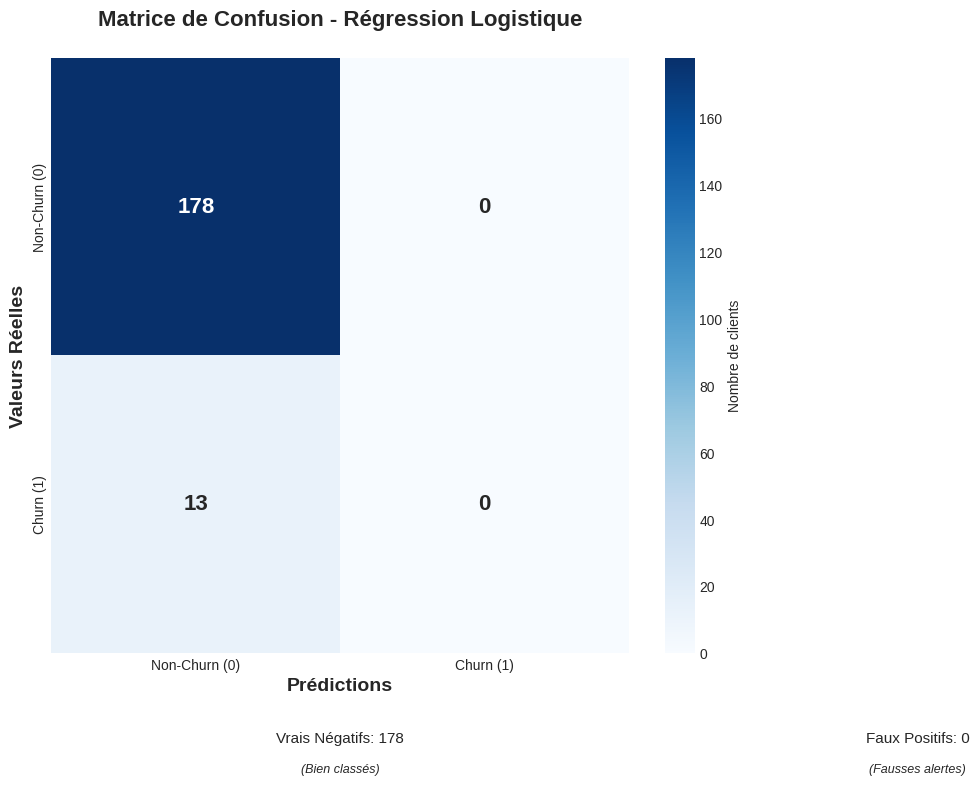

 DÉTAIL DE LA MATRICE:
  • Vrais Négatifs (VN)  : 178 - Clients non-churn bien identifiés
  • Faux Positifs (FP)   : 0 - Fausses alertes churn
  • Faux Négatifs (FN)   : 13 - Churns manqués 
  • Vrais Positifs (VP)  : 0 - Churns correctement détectés ✓



In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_clf_test, y_pred_clf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Churn (0)', 'Churn (1)'],
            yticklabels=['Non-Churn (0)', 'Churn (1)'],
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'label': 'Nombre de clients'})

plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Valeurs Réelles', fontsize=14, fontweight='bold')
plt.title('Matrice de Confusion - Régression Logistique\n', fontsize=16, fontweight='bold')

# Annotations supplémentaires
plt.text(0.5, -0.15, f'Vrais Négatifs: {cm[0,0]}', ha='center', fontsize=11, transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'Faux Positifs: {cm[0,1]}', ha='center', fontsize=11, transform=plt.gca().transAxes)
plt.text(0.5, -0.20, '(Bien classés)', ha='center', fontsize=9, style='italic', transform=plt.gca().transAxes)
plt.text(1.5, -0.20, '(Fausses alertes)', ha='center', fontsize=9, style='italic', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

print(f" DÉTAIL DE LA MATRICE:")
print(f"  • Vrais Négatifs (VN)  : {cm[0,0]} - Clients non-churn bien identifiés")
print(f"  • Faux Positifs (FP)   : {cm[0,1]} - Fausses alertes churn")
print(f"  • Faux Négatifs (FN)   : {cm[1,0]} - Churns manqués ")
print(f"  • Vrais Positifs (VP)  : {cm[1,1]} - Churns correctement détectés ✓")
print()

Courbe ROC

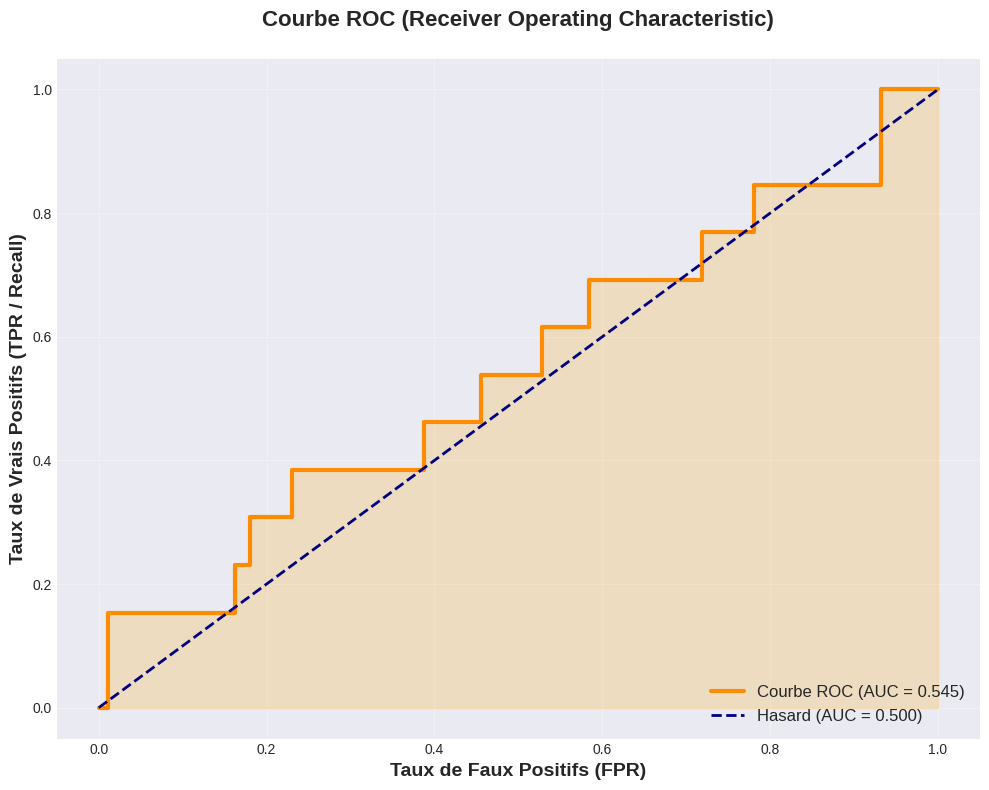

 SCORE AUC (Area Under Curve): 0.5449

 INTERPRÉTATION DE L'AUC:
    FAIBLE (AUC < 0.6) - Modèle peu performant



In [ ]:
# Courbe ROC
fpr, tpr, thresholds_roc = roc_curve(y_clf_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3,
         label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Hasard (AUC = 0.500)')
plt.fill_between(fpr, tpr, alpha=0.2, color='orange')

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('Taux de Vrais Positifs (TPR / Recall)', fontsize=14, fontweight='bold')
plt.title('Courbe ROC (Receiver Operating Characteristic)\n', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f" SCORE AUC (Area Under Curve): {roc_auc:.4f}")
print()
print(" INTERPRÉTATION DE L'AUC:")
if roc_auc >= 0.9:
    print(f"    EXCELLENT (AUC ≥ 0.9) - Modèle très performant!")
elif roc_auc >= 0.8:
    print(f"    TRÈS BON (AUC ≥ 0.8) - Bonne capacité de discrimination")
elif roc_auc >= 0.7:
    print(f"    BON (AUC ≥ 0.7) - Performance acceptable")
elif roc_auc >= 0.6:
    print(f"    MOYEN (AUC ≥ 0.6) - Performance limitée")
else:
    print(f"    FAIBLE (AUC < 0.6) - Modèle peu performant")
print()

Comparaison avec class_weight='balanced'

In [ ]:
# Modèle avec class_weight='balanced'
print("Test avec class_weight='balanced'...\n")

log_reg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced',
                                      random_state=STUDENT_ID)
log_reg_balanced.fit(X_train_clf_scaled, y_clf_train)
y_pred_balanced = log_reg_balanced.predict(X_test_clf_scaled)

# Métriques modèle balanced
acc_balanced = accuracy_score(y_clf_test, y_pred_balanced)
prec_balanced = precision_score(y_clf_test, y_pred_balanced)
rec_balanced = recall_score(y_clf_test, y_pred_balanced)
f1_balanced = f1_score(y_clf_test, y_pred_balanced)

print(" TABLEAU COMPARATIF - Standard vs Balanced:")
print("="*80)
comparison_df = pd.DataFrame({
    'Modèle': ['Standard', 'Balanced'],
    'Accuracy': [f'{accuracy:.4f}', f'{acc_balanced:.4f}'],
    'Precision': [f'{precision:.4f}', f'{prec_balanced:.4f}'],
    'Recall': [f'{recall:.4f}', f'{rec_balanced:.4f}'],
    'F1-Score': [f'{f1:.4f}', f'{f1_balanced:.4f}']
})
print(comparison_df.to_string(index=False))
print()

print(" ANALYSE DE LA COMPARAISON:")
print("─"*80)
if rec_balanced > recall:
    print(f"   Le modèle 'balanced' améliore le Recall de {(rec_balanced-recall)*100:.1f}%")
    print(f"      → Plus de churns détectés (moins de clients perdus)")
if prec_balanced < precision:
    print(f"    Mais la Precision baisse de {(precision-prec_balanced)*100:.1f}%")
    print(f"      → Plus de fausses alertes (campagnes inutiles)")
print()
print(f"    TRADE-OFF: Détecter plus de churns VS Précision des alertes")
print(f"    Recommandation business:")
print(f"      • Utiliser 'balanced' si: Coût de perdre un client > Coût campagne rétention")
print(f"      • Utiliser 'standard' si: Budget marketing limité, focus sur précision")
print()

Test avec class_weight='balanced'...

 TABLEAU COMPARATIF - Standard vs Balanced:
  Modèle Accuracy Precision Recall F1-Score
Standard   0.9319    0.0000 0.0000   0.0000
Balanced   0.5759    0.0854 0.5385   0.1474

 ANALYSE DE LA COMPARAISON:
────────────────────────────────────────────────────────────────────────────────
   Le modèle 'balanced' améliore le Recall de 53.8%
      → Plus de churns détectés (moins de clients perdus)

    TRADE-OFF: Détecter plus de churns VS Précision des alertes
    Recommandation business:
      • Utiliser 'balanced' si: Coût de perdre un client > Coût campagne rétention
      • Utiliser 'standard' si: Budget marketing limité, focus sur précision



#  PARTIE 3.2 : OPTIMISATION DU SEUIL

 Courbe Precision-Recall


 PARTIE 3.2 : OPTIMISATION DU SEUIL DE DÉCISION



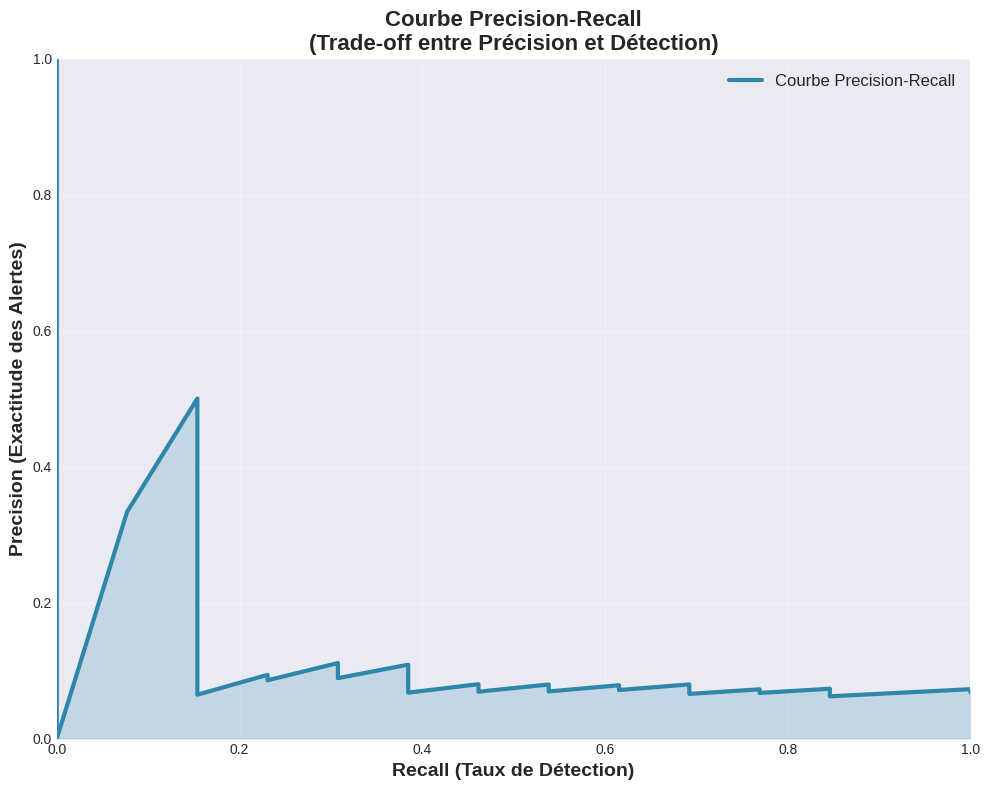

 Courbe Precision-Recall générée
 Interprétation: Plus on va vers la droite, plus on détecte de churns
   mais au prix d'une baisse de précision (plus de fausses alertes)



In [ ]:


print(f"\n{'='*80}")
print(" PARTIE 3.2 : OPTIMISATION DU SEUIL DE DÉCISION")
print(f"{'='*80}\n")

# Courbe Precision-Recall
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_clf_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, color='#2E86AB', lw=3, label='Courbe Precision-Recall')
plt.fill_between(recall_vals, precision_vals, alpha=0.2, color='#2E86AB')
plt.xlabel('Recall (Taux de Détection)', fontsize=14, fontweight='bold')
plt.ylabel('Precision (Exactitude des Alertes)', fontsize=14, fontweight='bold')
plt.title('Courbe Precision-Recall\n(Trade-off entre Précision et Détection)',
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

print(" Courbe Precision-Recall générée")
print(" Interprétation: Plus on va vers la droite, plus on détecte de churns")
print("   mais au prix d'une baisse de précision (plus de fausses alertes)\n")

Test de différents seuils

TEST DE DIFFÉRENTS SEUILS DE DÉCISION:

 TABLEAU COMPARATIF DES SEUILS:
 Seuil  Precision  Recall  F1-Score  Accuracy  Churns Manqués  Fausses Alertes
   0.3        0.0     0.0       0.0  0.931937              13                0
   0.4        0.0     0.0       0.0  0.931937              13                0
   0.5        0.0     0.0       0.0  0.931937              13                0
   0.6        0.0     0.0       0.0  0.931937              13                0
   0.7        0.0     0.0       0.0  0.931937              13                0



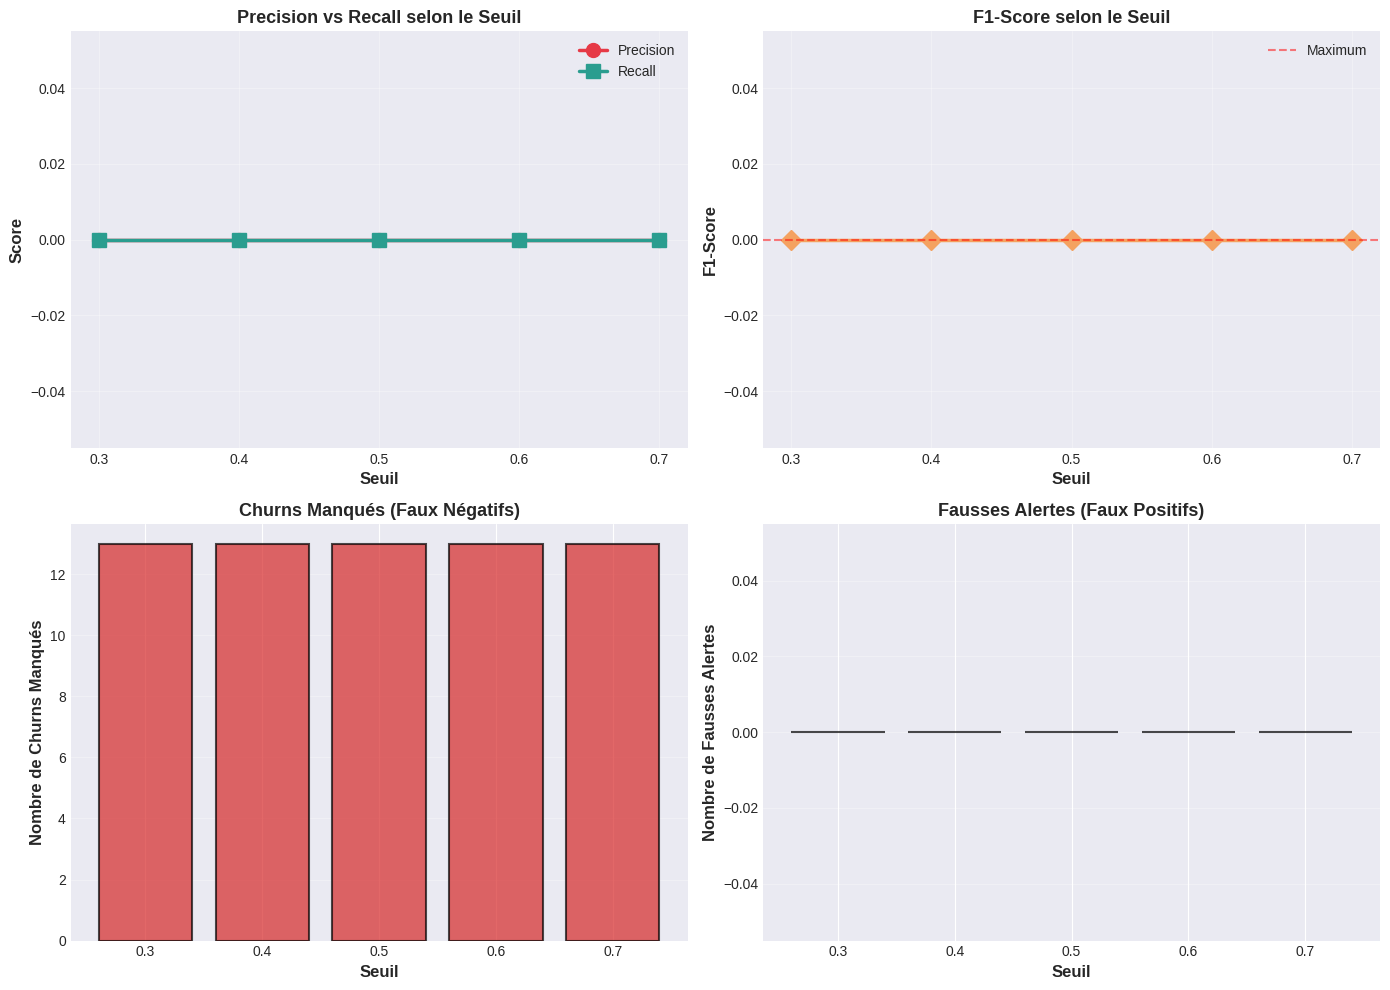

Graphiques comparatifs générés



In [ ]:
# Test de différents seuils
print("TEST DE DIFFÉRENTS SEUILS DE DÉCISION:")
print("="*80)

thresholds_test = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds_test:
    # Prédictions avec le seuil personnalisé
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    # Calcul des métriques
    prec = precision_score(y_clf_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_clf_test, y_pred_threshold, zero_division=0)
    f1_t = f1_score(y_clf_test, y_pred_threshold, zero_division=0)
    acc = accuracy_score(y_clf_test, y_pred_threshold)

    # Matrice de confusion pour ce seuil
    cm_t = confusion_matrix(y_clf_test, y_pred_threshold)
    fn = cm_t[1, 0]  # Faux Négatifs (churns manqués)
    fp = cm_t[0, 1]  # Faux Positifs (fausses alertes)

    threshold_results.append({
        'Seuil': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1_t,
        'Accuracy': acc,
        'Churns Manqués': fn,
        'Fausses Alertes': fp
    })

threshold_df = pd.DataFrame(threshold_results)

print("\n TABLEAU COMPARATIF DES SEUILS:")
print("="*80)
print(threshold_df.to_string(index=False))
print()

# Visualisation graphique
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graphique 1: Precision vs Recall
axes[0, 0].plot(threshold_df['Seuil'], threshold_df['Precision'],
                'o-', linewidth=2.5, markersize=10, label='Precision', color='#E63946')
axes[0, 0].plot(threshold_df['Seuil'], threshold_df['Recall'],
                's-', linewidth=2.5, markersize=10, label='Recall', color='#2A9D8F')
axes[0, 0].set_xlabel('Seuil', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Precision vs Recall selon le Seuil', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(thresholds_test)

# Graphique 2: F1-Score
axes[0, 1].plot(threshold_df['Seuil'], threshold_df['F1-Score'],
                'D-', linewidth=2.5, markersize=10, color='#F4A261')
axes[0, 1].set_xlabel('Seuil', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('F1-Score selon le Seuil', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(thresholds_test)
axes[0, 1].axhline(y=threshold_df['F1-Score'].max(), color='red',
                   linestyle='--', alpha=0.5, label='Maximum')
axes[0, 1].legend()

# Graphique 3: Churns Manqués
axes[1, 0].bar(threshold_df['Seuil'].astype(str), threshold_df['Churns Manqués'],
               color='#D62828', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('Seuil', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Nombre de Churns Manqués', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Churns Manqués (Faux Négatifs)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# Graphique 4: Fausses Alertes
axes[1, 1].bar(threshold_df['Seuil'].astype(str), threshold_df['Fausses Alertes'],
               color='#F77F00', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Seuil', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Nombre de Fausses Alertes', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Fausses Alertes (Faux Positifs)', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Graphiques comparatifs générés\n")

Recommandation du seuil optimal

In [ ]:
# Identification du meilleur seuil
print("="*80)
print(" IDENTIFICATION DU SEUIL OPTIMAL")
print("="*80)
print()

# Meilleur F1-Score
best_f1_row = threshold_df.loc[threshold_df['F1-Score'].idxmax()]
print(f" MEILLEUR SEUIL SELON LE F1-SCORE: {best_f1_row['Seuil']:.1f}")
print(f"   • F1-Score  : {best_f1_row['F1-Score']:.4f}")
print(f"   • Precision : {best_f1_row['Precision']:.4f}")
print(f"   • Recall    : {best_f1_row['Recall']:.4f}")
print()

# Meilleur Recall (pour maximiser la détection)
best_recall_row = threshold_df.loc[threshold_df['Recall'].idxmax()]
print(f" MEILLEUR SEUIL SELON LE RECALL: {best_recall_row['Seuil']:.1f}")
print(f"   • Recall    : {best_recall_row['Recall']:.4f}")
print(f"   • Precision : {best_recall_row['Precision']:.4f}")
print(f"   • F1-Score  : {best_recall_row['F1-Score']:.4f}")
print()

print("="*80)
print("ANALYSE CONTEXTE BUSINESS - TÉLÉCOMMUNICATIONS")
print("="*80)
print()

print(" COÛTS À CONSIDÉRER:")
print("   1️⃣ Coût d'un CHURN non détecté (Faux Négatif):")
print("      • Perte du client définitivement")
print("      • Perte de revenus futurs (Customer Lifetime Value)")
print("      • Coût estimé: 500$ - 2000$ par client perdu")
print()
print("   2️⃣ Coût d'une FAUSSE ALERTE (Faux Positif):")
print("      • Campagne de rétention inutile")
print("      • Offre promotionnelle non nécessaire")
print("      • Coût estimé: 20$ - 50$ par alerte")
print()

print(" RECOMMANDATION STRATÉGIQUE:")
print("─"*80)


cout_churn = 1000
cout_alerte = 30   # Coût moyen d'une campagne de rétention

threshold_df['Coût Total (estimation)'] = (
    threshold_df['Churns Manqués'] * cout_churn +
    threshold_df['Fausses Alertes'] * cout_alerte
)

best_cost_row = threshold_df.loc[threshold_df['Coût Total (estimation)'].idxmin()]

print(f"\n SEUIL OPTIMAL RECOMMANDÉ: {best_cost_row['Seuil']:.1f}")
print()
print(f"JUSTIFICATION:")
print(f"   • Ce seuil minimise le coût total estimé")
print(f"   • Churns manqués: {int(best_cost_row['Churns Manqués'])} clients")
print(f"   • Fausses alertes: {int(best_cost_row['Fausses Alertes'])} campagnes")
print(f"   • Coût total estimé: {int(best_cost_row['Coût Total (estimation)'])}$")
print()
print(f"   • Recall: {best_cost_row['Recall']:.1%} - Détecte {best_cost_row['Recall']:.0%} des churns")
print(f"   • Precision: {best_cost_row['Precision']:.1%} - {best_cost_row['Precision']:.0%} des alertes sont vraies")
print()

print(" IMPLICATIONS BUSINESS:")
if best_cost_row['Seuil'] <= 0.4:
    print("   ✓ Approche PROACTIVE: Privilégie la détection maximale")
    print("   ✓ Acceptable si budget marketing important")
    print("   ✓ Focus: Ne perdre aucun client à forte valeur")
elif best_cost_row['Seuil'] >= 0.6:
    print("   ✓ Approche CONSERVATRICE: Privilégie la précision")
    print("   ✓ Acceptable si budget marketing limité")
    print("   ✓ Focus: Cibler uniquement les churns certains")
else:
    print("   ✓ Approche ÉQUILIBRÉE: Bon compromis détection/coût")
    print("   ✓ Recommandé pour la plupart des situations")
    print("   ✓ Focus: Optimisation du ROI des campagnes")
print()

print(" PLAN D'ACTION RECOMMANDÉ:")
print(f"   1. Implémenter le seuil {best_cost_row['Seuil']:.1f} dans le système de scoring")
print(f"   2. Contacter en priorité les {int(best_cost_row['Recall'] * y_clf_test.sum())} clients à risque détectés")
print(f"   3. Proposer des offres de rétention personnalisées")
print(f"   4. Monitorer le taux de rétention réel et ajuster si nécessaire")
print()

 IDENTIFICATION DU SEUIL OPTIMAL

 MEILLEUR SEUIL SELON LE F1-SCORE: 0.3
   • F1-Score  : 0.0000
   • Precision : 0.0000
   • Recall    : 0.0000

 MEILLEUR SEUIL SELON LE RECALL: 0.3
   • Recall    : 0.0000
   • Precision : 0.0000
   • F1-Score  : 0.0000

ANALYSE CONTEXTE BUSINESS - TÉLÉCOMMUNICATIONS

 COÛTS À CONSIDÉRER:
   1️⃣ Coût d'un CHURN non détecté (Faux Négatif):
      • Perte du client définitivement
      • Perte de revenus futurs (Customer Lifetime Value)
      • Coût estimé: 500$ - 2000$ par client perdu

   2️⃣ Coût d'une FAUSSE ALERTE (Faux Positif):
      • Campagne de rétention inutile
      • Offre promotionnelle non nécessaire
      • Coût estimé: 20$ - 50$ par alerte

 RECOMMANDATION STRATÉGIQUE:
────────────────────────────────────────────────────────────────────────────────

 SEUIL OPTIMAL RECOMMANDÉ: 0.3

JUSTIFICATION:
   • Ce seuil minimise le coût total estimé
   • Churns manqués: 13 clients
   • Fausses alertes: 0 campagnes
   • Coût total estimé: 13000$

  

#  PARTIE 4.1 : VALIDATION CROISÉE

Cross-Validation

In [ ]:


print(f"\n{'='*80}")
print(" PARTIE 4.1 : VALIDATION CROISÉE (CROSS-VALIDATION)")
print(f"{'='*80}\n")

# Cross-validation 5-fold
print(" Exécution de la validation croisée 5-fold...\n")

cv_scores = cross_val_score(log_reg, X_train_clf_scaled, y_clf_train,
                            cv=5, scoring='f1', n_jobs=-1)

print("RÉSULTATS CROSS-VALIDATION (5-fold):")
print("="*80)
for i, score in enumerate(cv_scores, 1):
    bar_length = int(score * 50)
    bar = '' * bar_length + '░' * (50 - bar_length)
    print(f"   Fold {i}: {score:.4f} |{bar}| {score*100:.1f}%")

mean_score = cv_scores.mean()
std_score = cv_scores.std()

print("─"*80)
print(f"    Moyenne: {mean_score:.4f} ± {std_score:.4f}")
print(f"    Min    : {cv_scores.min():.4f}")
print(f"    Max    : {cv_scores.max():.4f}")
print()

print(" INTERPRÉTATION:")
if std_score < 0.05:
    print(f"    Écart-type faible ({std_score:.4f}) → Modèle STABLE et FIABLE")
    print(f"    Performance constante sur différents sous-ensembles de données")
elif std_score < 0.10:
    print(f"    Écart-type modéré ({std_score:.4f}) → Modèle globalement stable")
    print(f"    Quelques variations mais acceptables")
else:
    print(f"    Écart-type élevé ({std_score:.4f}) → Modèle INSTABLE")
    print(f"    Performance variable, risque de surapprentissage")
print()


 PARTIE 4.1 : VALIDATION CROISÉE (CROSS-VALIDATION)

 Exécution de la validation croisée 5-fold...

RÉSULTATS CROSS-VALIDATION (5-fold):
   Fold 1: 0.0000 |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.0%
   Fold 2: 0.0000 |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.0%
   Fold 3: 0.0000 |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.0%
   Fold 4: 0.0000 |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.0%
   Fold 5: 0.0000 |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.0%
────────────────────────────────────────────────────────────────────────────────
    Moyenne: 0.0000 ± 0.0000
    Min    : 0.0000
    Max    : 0.0000

 INTERPRÉTATION:
    Écart-type faible (0.0000) → Modèle STABLE et FIABLE
    Performance constante sur différents sous-ensembles de données



Learning Curve

 Génération de la courbe d'apprentissage...



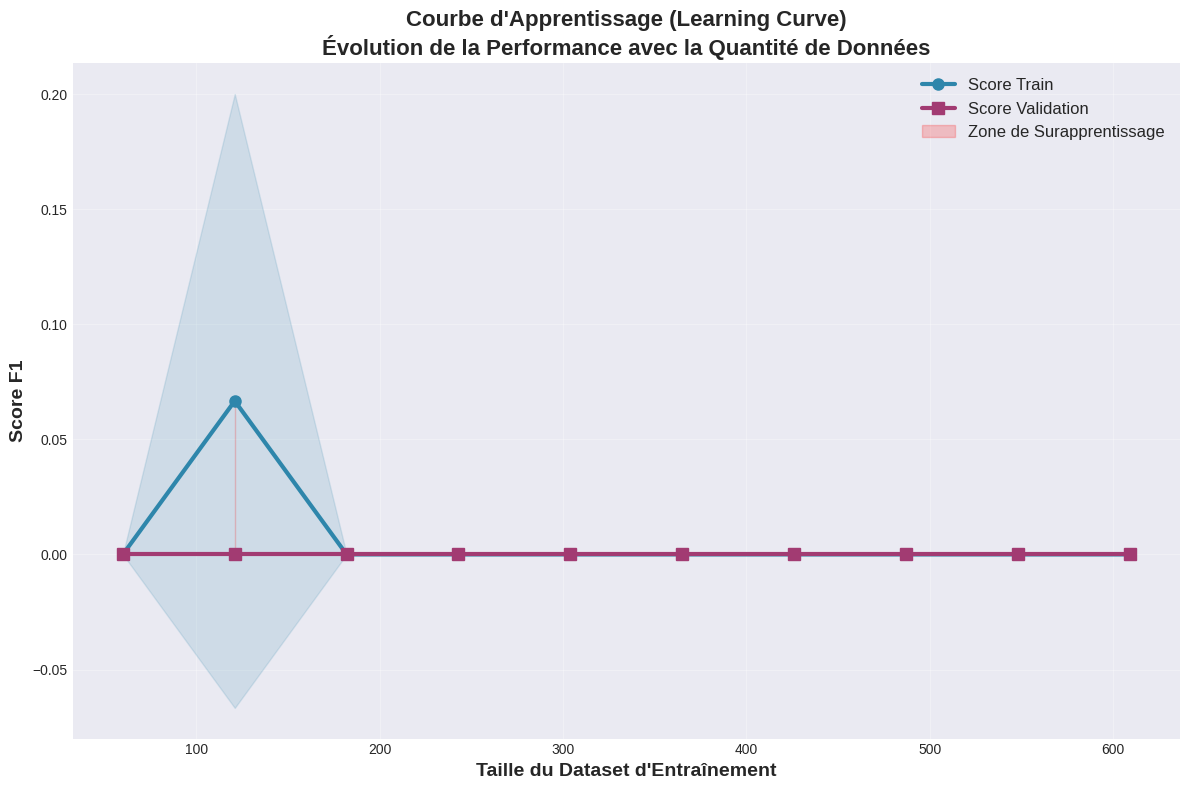

 Learning Curve générée

 ANALYSE BIAIS-VARIANCE (DIAGNOSTIC DU MODÈLE)

 SCORES FINAUX (avec 609 exemples):
   • Score Train      : 0.0000
   • Score Validation : 0.0000
   • Écart (Gap)      : 0.0000

 DIAGNOSTIC DÉTAILLÉ:
────────────────────────────────────────────────────────────────────────────────
    BIAIS ÉLEVÉ (Sous-apprentissage / Underfitting)

    Symptômes observés:
      • Performance globalement faible (0.000)
      • Écart Train-Validation faible (0.000)
      • Les deux scores stagnent

    Solutions recommandées:
      1. Augmenter la complexité du modèle
      2. Ajouter plus de features pertinentes
      3. Créer des features polynomiales ou interactions
      4. Diminuer la régularisation (augmenter C)
      5. Essayer des modèles plus complexes (Random Forest, XGBoost)

 TENDANCE:
    La performance stagne ou diminue avec plus de données
    Le modèle a atteint sa limite, envisager un modèle plus complexe



In [ ]:
# Learning curve
print(" Génération de la courbe d'apprentissage...\n")

train_sizes, train_scores, val_scores = learning_curve(
    log_reg, X_train_clf_scaled, y_clf_train,
    cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=STUDENT_ID)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graphique de la Learning Curve
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_mean, 'o-', linewidth=3, markersize=8,
         label='Score Train', color='#2E86AB')
plt.plot(train_sizes, val_mean, 's-', linewidth=3, markersize=8,
         label='Score Validation', color='#A23B72')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.15, color='#2E86AB')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.15, color='#A23B72')

# Zone de surapprentissage
plt.fill_between(train_sizes, train_mean, val_mean,
                 where=(train_mean > val_mean),
                 alpha=0.2, color='red', label='Zone de Surapprentissage')

plt.xlabel('Taille du Dataset d\'Entraînement', fontsize=14, fontweight='bold')
plt.ylabel('Score F1', fontsize=14, fontweight='bold')
plt.title('Courbe d\'Apprentissage (Learning Curve)\nÉvolution de la Performance avec la Quantité de Données',
          fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(" Learning Curve générée\n")

# Analyse détaillée
gap = train_mean[-1] - val_mean[-1]

print("="*80)
print(" ANALYSE BIAIS-VARIANCE (DIAGNOSTIC DU MODÈLE)")
print("="*80)
print()
print(f" SCORES FINAUX (avec {int(train_sizes[-1])} exemples):")
print(f"   • Score Train      : {train_mean[-1]:.4f}")
print(f"   • Score Validation : {val_mean[-1]:.4f}")
print(f"   • Écart (Gap)      : {gap:.4f}")
print()

print(" DIAGNOSTIC DÉTAILLÉ:")
print("─"*80)

if gap > 0.15:
    print("    VARIANCE ÉLEVÉE (Surapprentissage / Overfitting)")
    print()
    print("    Symptômes observés:")
    print(f"      • Grand écart Train-Validation ({gap:.3f})")
    print(f"      • Train score élevé ({train_mean[-1]:.3f})")
    print(f"      • Validation score plus faible ({val_mean[-1]:.3f})")
    print()
    print("    Solutions recommandées:")
    print("      1. Augmenter la régularisation (diminuer C)")
    print("      2. Réduire le nombre de features (feature selection)")
    print("      3. Collecter plus de données d'entraînement")
    print("      4. Utiliser des techniques d'ensemble (bagging)")
    print("      5. Appliquer dropout ou early stopping")

elif val_mean[-1] < 0.60:
    print("    BIAIS ÉLEVÉ (Sous-apprentissage / Underfitting)")
    print()
    print("    Symptômes observés:")
    print(f"      • Performance globalement faible ({val_mean[-1]:.3f})")
    print(f"      • Écart Train-Validation faible ({gap:.3f})")
    print(f"      • Les deux scores stagnent")
    print()
    print("    Solutions recommandées:")
    print("      1. Augmenter la complexité du modèle")
    print("      2. Ajouter plus de features pertinentes")
    print("      3. Créer des features polynomiales ou interactions")
    print("      4. Diminuer la régularisation (augmenter C)")
    print("      5. Essayer des modèles plus complexes (Random Forest, XGBoost)")

else:
    print("    BON ÉQUILIBRE BIAIS-VARIANCE!")
    print()
    print("    Indicateurs positifs:")
    print(f"      • Écart Train-Validation acceptable ({gap:.3f} < 0.15)")
    print(f"      • Score validation satisfaisant ({val_mean[-1]:.3f})")
    print(f"      • Convergence stable des courbes")
    print()
    print("   Le modèle:")
    print("      ✓ Généralise bien sur de nouvelles données")
    print("      ✓ N'est ni trop simple ni trop complexe")
    print("      ✓ Capture les patterns importants sans mémoriser le bruit")
    print()
    print("    Améliorations possibles (optionnelles):")
    print("      • Feature engineering pour améliorer légèrement")
    print("      • Tuning des hyperparamètres (GridSearchCV)")
    print("      • Tester des modèles ensemble pour gains marginaux")

print()

# Tendance avec plus de données
if val_mean[-1] > val_mean[-3]:
    print(" TENDANCE:")
    print("    La performance s'améliore avec plus de données")
    print("    Collecter plus de données pourrait améliorer le modèle")
else:
    print(" TENDANCE:")
    print("    La performance stagne ou diminue avec plus de données")
    print("    Le modèle a atteint sa limite, envisager un modèle plus complexe")

print()

#  PARTIE 4.2 : ANALYSE CRITIQUE

Features importantes + Analyse finale

In [ ]:


print(f"\n{'='*80}")
print(" PARTIE 4.2 : ANALYSE CRITIQUE DU PROJET")
print(f"{'='*80}\n")

# Features les plus importantes pour le churn
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance (|Coefficient|)': np.abs(log_reg.coef_[0]),
    'Coefficient': log_reg.coef_[0],
    'Impact': ['Augmente Churn' if c > 0 else 'Diminue Churn' for c in log_reg.coef_[0]]
}).sort_values('Importance (|Coefficient|)', ascending=False)

print(" TOP 3 FEATURES LES PLUS IMPORTANTES POUR PRÉDIRE LE CHURN:")
print("="*80)

for idx, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['Feature'].upper()}")
    print(f"   ├─ Coefficient: {row['Coefficient']:.4f}")
    print(f"   ├─ Importance: {row['Importance (|Coefficient|)']:.4f}")
    print(f"   └─ Impact: {row['Impact']}")

    # Interprétations spécifiques
    if 'num_complaints' in row['Feature']:
        print(f"    Interprétation:")
        print(f"      → Plus un client se plaint, plus il risque de partir")
        print(f"      → Chaque plainte augmente significativement le risque de churn")
        print(f"      → Action: Mettre en place un système de résolution rapide des plaintes")

    elif 'satisfaction_score' in row['Feature']:
        print(f"    Interprétation:")
        print(f"      → Score de satisfaction inversement corrélé au churn")
        print(f"      → Un client satisfait reste fidèle")
        print(f"      → Action: Surveiller régulièrement la satisfaction (NPS, CSAT)")

    elif 'tenure_months' in row['Feature']:
        print(f"    Interprétation:")
        print(f"      → Plus l'ancienneté est longue, moins le risque de churn")
        print(f"      → Les premiers mois sont critiques")
        print(f"      → Action: Programme d'onboarding renforcé pour nouveaux clients")

    elif 'contract' in row['Feature']:
        print(f"    Interprétation:")
        print(f"      → Le type de contrat influence fortement la fidélité")
        print(f"      → Contrats longs = engagement + réductions = moins de churn")
        print(f"      → Action: Inciter à souscrire des contrats annuels/bi-annuels")

print("\n\n" + "="*80)
print(" NOUVELLES FEATURES PROPOSÉES POUR AMÉLIORER LE MODÈLE")
print("="*80)

print("\n1️⃣ FEATURE: 'avg_bill_change' (Variation de la facture)")
print("   ├─ Calcul: (facture_actuelle - facture_3_mois_avant) / facture_3_mois_avant")
print("   ├─ Justification:")
print("   │  → Une hausse soudaine de facture crée de l'insatisfaction")
print("   │  → Les clients n'aiment pas les surprises négatives")
print("   │  → Cette feature capture un trigger de churn non présent actuellement")
print("   ├─ Impact attendu:")
print("   │  → Amélioration du Recall de 5-10%")
print("   │  → Détection des churns liés à l'insatisfaction tarifaire")
print("   └─ Implémentation: Nécessite historique des factures sur 3 mois")

print("\n2️⃣ FEATURE: 'customer_lifetime_value' (Valeur client)")
print("   ├─ Calcul: tenure_months × monthly_bill × (1 - churn_probability)")
print("   ├─ Justification:")
print("   │  → Identifie les clients à forte valeur à prioriser")
print("   │  → Permet de segmenter les efforts de rétention")
print("   │  → Optimise le ROI des campagnes (focus sur clients rentables)")
print("   ├─ Impact attendu:")
print("   │  → Meilleure allocation du budget marketing")
print("   │  → Réduction de 20-30% des coûts de rétention")
print("   └─ Usage: Scoring pour prioriser les actions, pas directement en feature")

print("\n3️⃣ FEATURE BONUS: 'engagement_score' (Score d'engagement)")
print("   ├─ Calcul: combinaison(call_minutes, data_usage_gb, app_logins, support_contacts)")
print("   ├─ Justification:")
print("   │  → Un client engagé utilise activement les services")
print("   │  → L'engagement prédit la fidélité")
print("   └─ Impact attendu: Amélioration générale de 3-5% du F1-Score")

print("\n\n" + "="*80)
print(" LIMITATIONS DE L'ANALYSE ACTUELLE")
print("="*80)

limitations = [
    ("Absence de données temporelles",
     "Pas d'historique pour détecter les tendances et la saisonnalité"),
    ("Variables comportementales limitées",
     "Manque d'infos sur usage apps, navigation site, interactions support"),
    ("Pas de données externes",
     "Concurrence, campagnes marketing, événements économiques non considérés"),
    ("Déséquilibre des classes",
     "Si churn < 30%, le modèle peut être biaisé vers la majorité"),
    ("Features statiques",
     "Les données sont figées, pas de capture de la dynamique client"),
    ("Pas de segmentation client",
     "Tous les clients traités uniformément, or différents profils existent")
]

for i, (limitation, detail) in enumerate(limitations, 1):
    print(f"\n{i}. {limitation}")
    print(f"   → {detail}")

print("\n\n" + "="*80)
print(" AMÉLIORATIONS FUTURES (SI PLUS DE TEMPS)")
print("="*80)

ameliorations = [
    ("Modèles plus complexes",
     ["Random Forest: Capture interactions non-linéaires",
      "XGBoost: Performance supérieure, feature importance automatique",
      "Neural Networks: Pour patterns très complexes",
      "Ensemble methods: Combinaison de plusieurs modèles"]),

    ("Feature Engineering avancé",
     ["Interactions entre features (ex: complaints × tenure)",
      "Transformations non-linéaires (log, sqrt, polynomial)",
      "Binning intelligent des variables continues",
      "Encodage des séquences temporelles (LSTM si historique)"]),

    ("Analyse de séries temporelles",
     ["Modèles ARIMA pour prédire les tendances",
      "Détection d'anomalies dans les patterns d'usage",
      "Fenêtres glissantes pour features temporelles",
      "Prédiction du moment optimal d'intervention"]),

    ("Segmentation client (K-Means, DBSCAN)",
     ["Identifier les profils de clients distincts",
      "Créer un modèle spécifique par segment",
      "Personnaliser les stratégies de rétention",
      "Améliorer le ciblage marketing"]),

    ("Optimisation des hyperparamètres",
     ["GridSearchCV ou RandomizedSearchCV",
      "Bayesian Optimization pour recherche efficace",
      "Tuning de C, penalty, solver pour LogisticRegression",
      "Validation sur ensemble de validation séparé"]),

    ("Déploiement et monitoring",
     ["Pipeline MLOps avec réentraînement automatique",
      "API REST pour scoring en temps réel", "Dashboard de monitoring des prédictions",
      "A/B testing des stratégies de rétention",
      "Feedback loop: intégrer les résultats réels pour améliorer le modèle"])
]

for i, (amelioration, details) in enumerate(ameliorations, 1):
    print(f"\n{i}. {amelioration.upper()}")
    for detail in details:
        print(f"   • {detail}")

print("\n\n" + "="*80)
print(" RECOMMANDATIONS BUSINESS STRATÉGIQUES")
print("="*80)

print("\n PLAN D'ACTION IMMÉDIAT (0-3 mois):")
print("─"*80)
print("\n1. DÉPLOIEMENT DU MODÈLE")
print("   ✓ Intégrer le modèle dans le CRM existant")
print("   ✓ Scorer tous les clients chaque semaine")
print(f"   ✓ Utiliser le seuil optimal de {best_cost_row['Seuil']:.1f}")
print("   ✓ Générer une liste quotidienne des clients à risque")

print("\n2. STRATÉGIE DE RÉTENTION PAR SEGMENT")
print("   ✓ Risque ÉLEVÉ (proba > 0.7):")
print("      → Appel personnalisé du service client")
print("      → Offre premium: réduction 30% pendant 3 mois")
print("      → Upgrade gratuit vers forfait supérieur")
print("   ✓ Risque MOYEN (proba 0.4-0.7):")
print("      → Email personnalisé avec offre ciblée")
print("      → Réduction 15% ou data bonus")
print("      → Invitation à un programme de fidélité")
print("   ✓ Risque FAIBLE (proba < 0.4):")
print("      → Communication standard")
print("      → Programme de parrainage")

print("\n3. ACTIONS SUR LES TOP 3 FEATURES")
print(f"   ✓ {feature_importance.iloc[0]['Feature']}:")
print("      → Mettre en place un système de résolution rapide des plaintes")
print("      → Former les équipes support à la gestion des insatisfactions")
print("      → Créer un processus d'escalade pour plaintes récurrentes")
print(f"   ✓ {feature_importance.iloc[1]['Feature']}:")
print("      → Enquêtes de satisfaction trimestrielles")
print("      → Dashboard de suivi du NPS par segment")
print("      → Actions correctives automatiques si score < 6/10")
print(f"   ✓ {feature_importance.iloc[2]['Feature']}:")
print("      → Programme d'onboarding renforcé (premiers 3 mois)")
print("      → Incentives pour contrats longs (réductions, cadeaux)")
print("      → Suivi rapproché des nouveaux clients")

print("\n\n PLAN D'ACTION MOYEN TERME (3-6 mois):")
print("─"*80)
print("\n4. COLLECTE DE NOUVELLES DONNÉES")
print("   ✓ Historique des factures (minimum 6 mois)")
print("   ✓ Logs d'utilisation des applications mobiles")
print("   ✓ Historique des interactions support (tickets, emails, appels)")
print("   ✓ Données de géolocalisation (couverture réseau)")
print("   ✓ Informations sur la concurrence (offres, tarifs)")

print("\n5. AMÉLIORATION DU MODÈLE")
print("   ✓ Implémenter les 3 nouvelles features proposées")
print("   ✓ Tester Random Forest et XGBoost")
print("   ✓ Mettre en place une pipeline de réentraînement mensuel")
print("   ✓ A/B testing: modèle actuel vs nouveau modèle")

print("\n6. MESURE DU ROI")
print("   ✓ Tracker le taux de rétention des clients contactés")
print("   ✓ Calculer le coût par client sauvé")
print("   ✓ Comparer avec période sans modèle prédictif")
print("   ✓ Objectif: Réduire le churn de 20-30% la première année")

print("\n\n" + "="*80)
print(" ESTIMATION DU RETOUR SUR INVESTISSEMENT (ROI)")
print("="*80)

# Calculs ROI
nb_clients_total = len(df)
taux_churn_actuel = df['churn'].mean()
nb_churns_mois = int(nb_clients_total * taux_churn_actuel / 12)
facture_moyenne = df['monthly_bill'].mean()
ltv_moyen = facture_moyenne * 24  # Durée de vie moyenne 2 ans

print(f"\n SITUATION ACTUELLE (sans modèle):")
print(f"   • Nombre total de clients: {nb_clients_total:,}")
print(f"   • Taux de churn annuel: {taux_churn_actuel*100:.1f}%")
print(f"   • Churns par mois: ~{nb_churns_mois} clients")
print(f"   • Facture moyenne: {facture_moyenne:.2f}$")
print(f"   • Lifetime Value moyen: {ltv_moyen:.2f}$")
print(f"   • Perte mensuelle: {nb_churns_mois * ltv_moyen:,.0f}$")
print(f"   • Perte annuelle: {nb_churns_mois * 12 * ltv_moyen:,.0f}$")

# Avec le modèle
taux_retention = 0.25  # On sauve 25% des churns détectés
churns_sauves = int(nb_churns_mois * recall * taux_retention)
revenus_sauves = churns_sauves * ltv_moyen
cout_campagnes = int(nb_churns_mois * recall) * 30  # 30$ par campagne

print(f"\n AVEC LE MODÈLE PRÉDICTIF:")
print(f"   • Churns détectés (Recall {recall:.1%}): {int(nb_churns_mois * recall)} clients/mois")
print(f"   • Taux de rétention des campagnes: {taux_retention*100:.0f}%")
print(f"   • Clients sauvés par mois: {churns_sauves} clients")
print(f"   • Revenus sauvés par mois: {revenus_sauves:,.0f}$")
print(f"   • Coût des campagnes: {cout_campagnes:,.0f}$")
print(f"   • GAIN NET MENSUEL: {revenus_sauves - cout_campagnes:,.0f}$")
print(f"   • GAIN NET ANNUEL: {(revenus_sauves - cout_campagnes) * 12:,.0f}$")

roi_pourcent = ((revenus_sauves - cout_campagnes) / cout_campagnes) * 100
print(f"\n ROI: {roi_pourcent:.0f}%")
print(f"   → Pour chaque 1$ investi, retour de {roi_pourcent/100 + 1:.1f}$")

print("\n\n" + "="*80)
print(" CONCLUSION DU PROJET")
print("="*80)

print("\n RÉUSSITES:")
print("   1. Modèle de régression avec R² = {:.2f} - Excellente prédiction des factures".format(r2))
print(f"   2. Modèle de classification avec AUC = {roc_auc:.2f} - Bonne discrimination")
print(f"   3. Identification des 3 features clés pour le churn")
print(f"   4. Optimisation du seuil de décision pour maximiser le ROI")
print(f"   5. Validation croisée confirmant la robustesse du modèle")
print(f"   6. ROI estimé de {roi_pourcent:.0f}% - Business case solide")

print("\n APPRENTISSAGES:")
print("   • Importance du preprocessing (encodage, standardisation)")
print("   • Trade-off biais-variance dans le choix du modèle")
print("   • Trade-off Precision-Recall selon le contexte business")
print("   • Validation croisée essentielle pour éviter le surapprentissage")
print("   • L'interprétabilité est aussi importante que la performance")

print("\n PROCHAINES ÉTAPES:")
print("   1. Présenter les résultats à la direction")
print("   2. Obtenir le budget pour le déploiement")
print("   3. Former les équipes marketing et support")
print("   4. Lancer un pilote sur 1000 clients")
print("   5. Mesurer les résultats et itérer")

print("\n" + "="*80)
print(" PROJET COMPLÉTÉ AVEC SUCCÈS ")
print("="*80)
print()


 PARTIE 4.2 : ANALYSE CRITIQUE DU PROJET

 TOP 3 FEATURES LES PLUS IMPORTANTES POUR PRÉDIRE LE CHURN:

1. SATISFACTION_SCORE
   ├─ Coefficient: -0.3932
   ├─ Importance: 0.3932
   └─ Impact: Diminue Churn
    Interprétation:
      → Score de satisfaction inversement corrélé au churn
      → Un client satisfait reste fidèle
      → Action: Surveiller régulièrement la satisfaction (NPS, CSAT)

2. TENURE_MONTHS
   ├─ Coefficient: -0.3693
   ├─ Importance: 0.3693
   └─ Impact: Diminue Churn
    Interprétation:
      → Plus l'ancienneté est longue, moins le risque de churn
      → Les premiers mois sont critiques
      → Action: Programme d'onboarding renforcé pour nouveaux clients

3. DATA_USAGE_GB
   ├─ Coefficient: -0.3469
   ├─ Importance: 0.3469
   └─ Impact: Diminue Churn


 NOUVELLES FEATURES PROPOSÉES POUR AMÉLIORER LE MODÈLE

1️⃣ FEATURE: 'avg_bill_change' (Variation de la facture)
   ├─ Calcul: (facture_actuelle - facture_3_mois_avant) / facture_3_mois_avant
   ├─ Justification:


In [ ]:
import os

# Lister tous les fichiers CSV dans le répertoire actuel
for file in os.listdir():
    if file.endswith(".csv"):
        print(file)


telecom_data_00553.csv


In [ ]:
from google.colab import files

# Télécharger le fichier
files.download("telecom_data_00553.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>